In [1]:
import os
import numpy as np
import cv2  

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Flatten, Dropout, Reshape, Multiply, Permute, Flatten, Activation, Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from sklearn.model_selection import train_test_split
import shutil

2024-05-06 15:32:51.455837: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 15:32:51.455907: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 15:32:51.458459: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-06 15:32:52.711979: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [26]:
import warnings
warnings.filterwarnings('ignore')

# Load data and create data generators

In [2]:
train_dir = os.path.join('./data/cats_and_dogs/', 'train')
test_dir = os.path.join('./data/cats_and_dogs/', 'test')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(150, 150),  
        batch_size=32,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 19998 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [6]:
def soft_attention(activation_layer):
    attention = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(activation_layer)
    attention = Reshape((activation_layer.shape[1], activation_layer.shape[2]))(attention)
    attention = Activation('softmax', name='attention_weights')(attention)
    attention = Reshape((activation_layer.shape[1], activation_layer.shape[2], 1))(attention)
    weighted_output = Multiply()([activation_layer, attention])
    return weighted_output

In [23]:
class SoftSpatialAttention(layers.Layer):
    def __init__(self):
        super(SoftSpatialAttention, self).__init__()

    def build(self, input_shape):
        self.conv2d_1 = Conv2D(filters=1, kernel_size=(1, 1), input_shape=input_shape, activation='sigmoid')
        self.conv2d_2 = Conv2D(filters=1, kernel_size=(1, 1), input_shape=input_shape, activation='sigmoid')
        self.reshape_1 = Reshape((-1,))
        self.activation = Activation('softmax', name='attentio_weights')
        self.reshape_2 = Reshape((input_shape[1], input_shape[2], 1)) 
        self.multiply = Multiply()

    def call(self, inputs):
        x = self.conv2d_1(inputs)
        x = self.conv2d_2(x)
        x = self.reshape_1(x)
        x = self.activation(x)
        x = self.reshape_2(x)

        out = self.multiply([x, inputs])

        return out
        """
        attention = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(attention)
        
        attention = Reshape((-1,))(attention)
        
        attention = Activation('softmax', name='attention_weights')(attention)
        
        attention = Reshape((activation_layer.shape[1], activation_layer.shape[2], 1))(attention)
        
        weighted_output = Multiply()([activation_layer, attention])
        
        return weighted_output
        """

# Attention 
Attention mechanism in neural networks aims to mimic human attention. It is usually defined using a Query, Key and Values. In a real life situation one could relate to queries keys and values with the following scenario. You are searching for a restaurant to have dinner, the attention mechanism would help you to focus on certain aspects of the restaurant (the values) based on your personal preferences (queries) and the information available (keys).

   - Queries could be the information you are looking for : italian, cheap, cosy.
   - Keys could be the information about each restaurant helping you to make a decision.
   - Values being the actual restaurant, the name for example.
  
The goal of attention mechanism is to compute a similarity between your query and the keys, in order to weight each values (restaurants), allowing to prioritize the restaurant matching your request as much as possible.

## Some background 

First Attention pooling idea can be attributed to Nadaraya–Watson kernel Regression. 
Nadaraya and Watson proposed to estimate $m$ as a locally weighted average, using a kernel as a weighting function : 

\begin{align}
    f(x) = \sum_{i=1}^n \frac{K(x - x_i)}{ \sum_{j=1}^n K(x - x_j)}y_i.
\end{align}

K being a kernel. In a more attention based perspective it can be written as : 

\begin{align}
    f(x) = \sum_{i=1}^n \alpha(x, x_i) y_i
\end{align}

$x$ being the keys, $x_i$ the query and $v$ the values and a the similarity function. 

Let's use a gaussian Kernel 
\begin{align}
    K(u) = \frac{1}{\sqrt{2\pi}}exp(-\frac{u^2}{2}).
\end{align}

Introducing the gaussian kernel in the previous equation : 

\begin{align}
    f(x) & = \sum_{i=1}^n \alpha(x, x_i) y_i \\
         & = \sum_{i=1}^n \frac{exp(-\frac{1}{2}(x - x_i)^2)}{\sum_{j=1}^n exp(-\frac{1}{2}(x-x_i)^2)}y_i \\
         & = \sum_{i=1}^n softmax\left( -\frac{1}{2}(x - x_i)^2 \right)y_i. 
\end{align}


We end up with a computation of the similarity between the query and the key $ -\frac{1}{2}(x - x_i)^2 $. Plugged into the softmax function to get a weight distribution. The label $y_i$ is the value. This derivation is just to display that kernel regression can be seen as a precursor of the modern attention formalism.


In [24]:
inputs = tf.keras.Input(shape=(150, 150, 3))

x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = Dropout(0.1)(x)

x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = Dropout(0.1)(x)

x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)

x = SoftSpatialAttention()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

X = tf.keras.layers.Dense(512, activation='relu')(x) 

outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_36 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 36, 36, 64)        0     

In [ ]:
model.fit(train_generator, epochs=30, verbose=1)

Epoch 1/30
309/625 [=============>................] - ETA: 1:52 - loss: 0.6240 - accuracy: 0.6477

In [10]:
model.evaluate(test_generator)

157/157 ━━━━━━━━━━━━━━━━━━━━ 55s 349ms/step - accuracy: 0.8866 - loss: 0.2624


[0.24958612024784088, 0.8967999815940857]

## Extracting attention layer

In [13]:
model.layers[13]

<Activation name=attention_weights, built=True>

In [16]:
attention = tf.keras.Model(inputs=model.inputs, outputs=[model.outputs[0], model.layers[13].output])
attention.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 148, 148,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 74, 74,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 72, 72,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 36, 36,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 36, 36,    │          0 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 34, 34,    │     73,856 │ dropout_2[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 17, 17,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 17, 17,    │          0 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 15, 15,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 7, 7, 128) │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 7, 7, 1)   │        129 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 7, 7)      │          0 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, 7, 7)      │          0 │ reshape_2[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 7, 7, 1)   │          0 │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 7, 7, 128) │          0 │ max_pooling2d_7[… │
│ (Multiply)          │                   │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ multiply_1[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        129 │ global_average_p

 Total params: 241,090 (941.76 KB)

 Trainable params: 241,090 (941.76 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
sample = next(train_generator)
pred, weights = attention.predict(sample[0])
print(weights[0].shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
(7, 7)


In [24]:
def visualize_attention():
    original_img = next(train_generator)

    pred, attention_weights = attention.predict(original_img[0])

    print(attention_weights.shape)
    
    attention_weights = cv2.resize(attention_weights[0], (original_img[0].shape[1], original_img[0].shape[1]))
 
    plt.imshow(original_img[0][0])  # Display the input image
    plt.show()
    plt.imshow(original_img[0][0])  # Display the input image
    plt.imshow(attention_weights, cmap='jet', alpha=0.4)  # Overlay the attention weights
    plt.colorbar()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
(32, 7, 7)


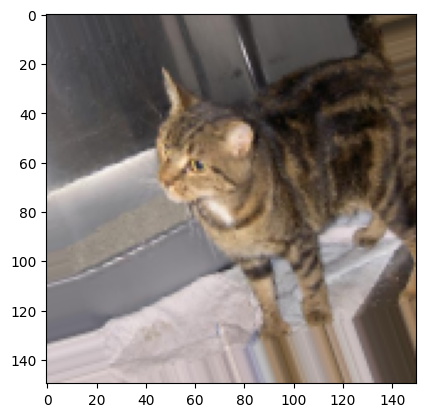

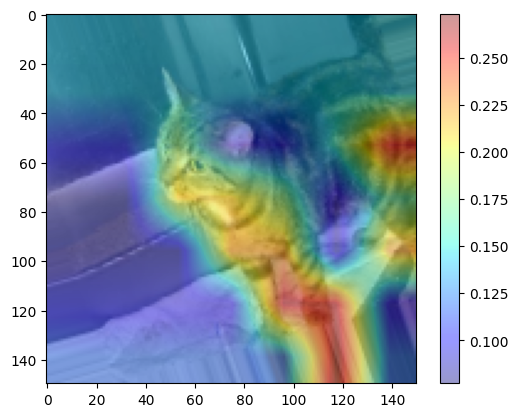

In [36]:
visualize_attention()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
(32, 1)


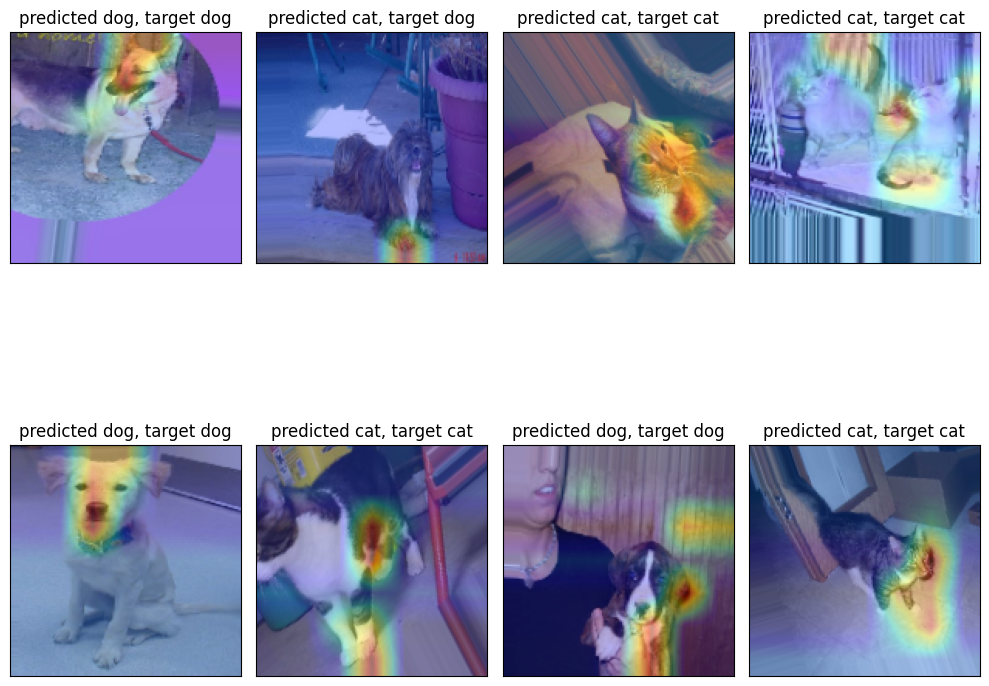

In [45]:
imgs, targets = next(train_generator)
preds, attention_weights = attention.predict(imgs)

print(preds.shape)

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10,10))
axs = axs.ravel()

for i in range(8):
    resized_attention_weights = cv2.resize(attention_weights[i], (imgs[i].shape[1], imgs[i].shape[1]))

    pred = 'dog' if np.round(preds[i]) == 1 else 'cat'
    target = 'dog' if targets[i] == 1 else 'cat'

    axs[i].imshow(imgs[i])  
    axs[i].imshow(resized_attention_weights, cmap='jet', alpha=0.3) 
    axs[i].title.set_text(f'predicted {pred}, target {target}')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    
plt.tight_layout()